In [38]:
from importlib.metadata import version
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


## Step 1. 인물모드 직접 해 보기
첫 번째 이미지 : 애기 강아지  
두 번째 이미지 : 앉아있는 강아지  
세 번째 이미지 : 사람  

이미지를 불러오는 과정 중 jpg에서 png 파일로 수정하는 과정을 거쳤다. 

### 1. 이미지 준비

In [56]:
### 이미지 준비 함수화
def image_loader(image_name:str):
    '''이미지를 불러오는 함수
    '''
    img_path = os.getenv('HOME')+f'/aiffel/human_segmentation/images/{image_name}.png'  
    img_orig = cv2.imread(img_path) 
    
    return img_orig, img_path

In [57]:
img_orig1, img_path1 = image_loader("리치1")
img_orig2, img_path2 = image_loader("리치2")
img_orig3, img_path3 = image_loader("myimage")

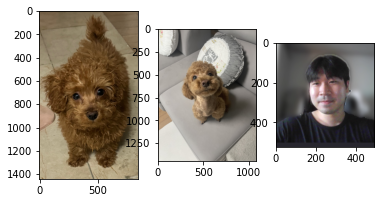

In [58]:
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

### 2. 모델 준비

In [59]:
### `PixelLib`에서 제공하는 모델 다운로드
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file) 

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7bf567471e50>)

In [60]:
### `PixelLib`로 사용할 segmantation 모델 생성
## 모델 선언
model = semantic_segmentation() 

## pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
model.load_pascalvoc_model(model_file)

### 3. 모델에 입력

In [92]:
### 모델에 이미지 입력
segvalues1, output1 = model.segmentAsPascalvoc(img_path1)
segvalues2, output2 = model.segmentAsPascalvoc(img_path2)
segvalues3, output3 = model.segmentAsPascalvoc(img_path3)

In [95]:
### 클래스 저장
class_ids1 = segvalues1["class_ids"]
class_ids2 = segvalues2["class_ids"]
class_ids3 = segvalues3["class_ids"]

In [96]:
### pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

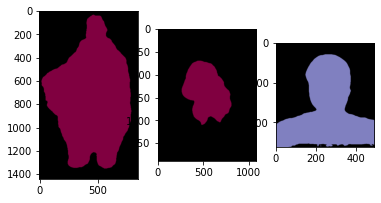

In [97]:
### 분할된 결과값 중 output을 시각화
plt.subplot(1,3,1)
plt.imshow(output1)
plt.subplot(1,3,2)
plt.imshow(output2)
plt.subplot(1,3,3)
plt.imshow(output3)
plt.show()

In [107]:
### class id 확인
for i, class_id in enumerate([class_ids1, class_ids2, class_ids3]):
    print(f"## {i+1} 사진의 class id")
    for _ in class_id:
        print(f"   {_} : {LABEL_NAMES[_]}")

## 1 사진의 class id
   0 : background
   12 : dog
## 2 사진의 class id
   0 : background
   12 : dog
## 3 사진의 class id
   0 : background
   15 : person


### 4. 색상 설정

In [108]:
### 컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

## 강아지 colormap 추출
print(colormap[12])
## 사람 colormap 추출 
print(colormap[15])

[ 64   0 128]
[192 128 128]


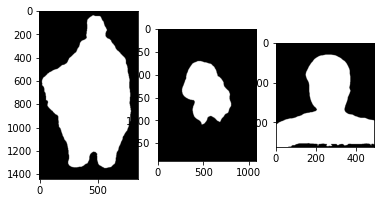

In [111]:
## 색상순서 변경
seg_color_dog = (128, 0, 64) ## BGR(64, 0, 128) -> RGB(128, 0, 64)
seg_color_person = (128, 128, 192) ## BGR(192, 128, 128) -> RGB(128, 128, 192)

plt.subplot(1,3,1)
seg_map1 = np.all(output1==seg_color_dog, axis=-1) 
plt.imshow(seg_map1, cmap='gray')

plt.subplot(1,3,2)
seg_map2 = np.all(output2==seg_color_dog, axis=-1) 
plt.imshow(seg_map2, cmap='gray')

plt.subplot(1,3,3)
seg_map3 = np.all(output3==seg_color_person, axis=-1) 
plt.imshow(seg_map3, cmap='gray')
plt.show()

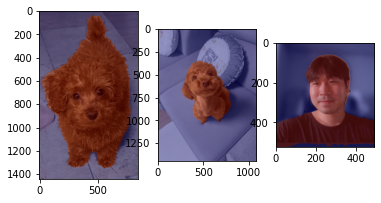

In [112]:
## 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show1 = img_orig1.copy()
img_show2 = img_orig2.copy()
img_show3 = img_orig3.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask1 = seg_map1.astype(np.uint8) * 255
img_mask2 = seg_map2.astype(np.uint8) * 255
img_mask3 = seg_map3.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask1 = cv2.applyColorMap(img_mask1, cv2.COLORMAP_JET)
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)
color_mask3 = cv2.applyColorMap(img_mask3, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show1 = cv2.addWeighted(img_show1, 0.6, color_mask1, 0.4, 0.0)
img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask2, 0.4, 0.0)
img_show3 = cv2.addWeighted(img_show3, 0.6, color_mask3, 0.4, 0.0)

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_show1, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))

plt.show()

### 5. 배경 흐리게 하기

In [138]:
def bgblur_processor(img_orig, img_mask):
    '''객체 없이 흐린 배경 추출하는 함수
    '''
    ## 전체 이미지 흐리게
    img_orig_blur = cv2.blur(img_orig, (50,50))
    
    ## 이미지 색상 변경 : BGR 형식을 RGB 형식으로 변경
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    
    ## 배경이 0 사람이 255 였으나 연산을 하고 나면 배경은 255 사람은 0입니다.
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    
    ## 배경만 있는 영상을 얻기
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    return img_mask_color, img_bg_blur

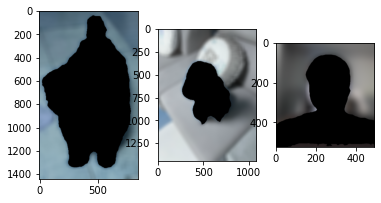

In [139]:
img_mask_color1, img_bg_blur1 = bgblur_processor(img_orig1, img_mask1)
img_mask_color2, img_bg_blur2 = bgblur_processor(img_orig2, img_mask2)
img_mask_color3, img_bg_blur3 = bgblur_processor(img_orig3, img_mask3)

plt.subplot(1,3,1)
plt.imshow(img_bg_blur1)

plt.subplot(1,3,2)
plt.imshow(img_bg_blur2)

plt.subplot(1,3,3)
plt.imshow(img_bg_blur3)

plt.show()

### 6. 흐린 배경에 합치기 

In [140]:
img_concat1 = np.where(img_mask_color1==255, img_orig1, img_bg_blur1)
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2)
img_concat3 = np.where(img_mask_color3==255, img_orig3, img_bg_blur3)

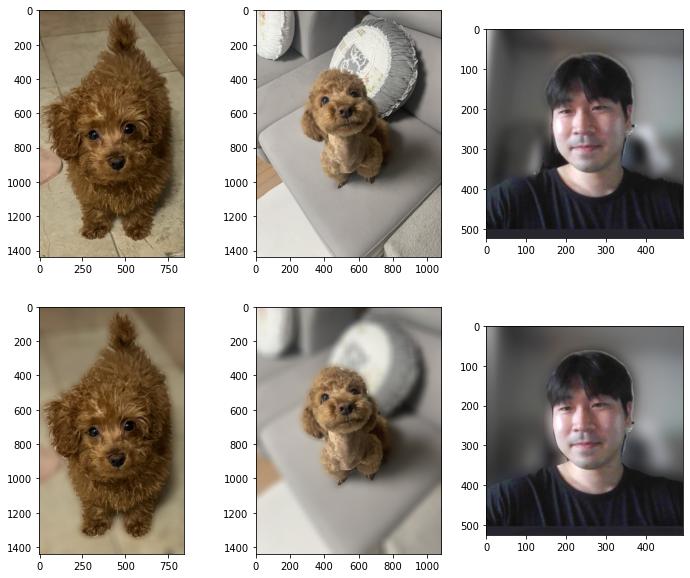

In [141]:
## 전후 비교
plt.figure(figsize=(12, 10))
plt.subplot(2,3,1)
plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))

plt.subplot(2,3,2)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))

plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))

plt.subplot(2,3,4)
plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))

plt.subplot(2,3,5)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))

plt.subplot(2,3,6)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))

plt.show()

1번과 2번의 경우 약간 흐려진 것 같다??  
흐린 정도를 더 진하게 할려면? -> kernel size를 (50, 50)으로 하니 되었다! 
3번 사람 사진의 경우 원래 배경이 흐려서 그대로 유지된 것 같다.

### Step 2. 사진에서 문제점 찾기

나의 이미지에는 뒤에 걸린 옷이라던지 그러한 문제점이 발견되지 않았다.  
강아지의 그림자의 경우 강아지로 인실하지 않았을까 하여 살펴보았지만 잘 구분되어있었다.   
그러나 저러한 문제점이 생긴다면 어떻게 해야할까?  

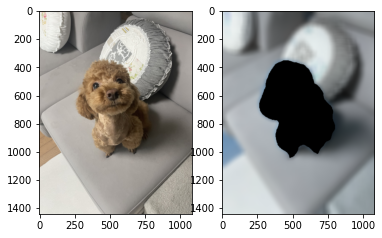

In [142]:
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.imshow(img_bg_blur2)
plt.show()

### Step 3. 해결 방법을 제안해 보기

### 회고
내가 갖고 있는 사진을 훈련된 모델에 입력만 했을 뿐인데 인물사진을 만들 수 있었다.  
훈련된 모델을 잘 사용할 줄 안다면 더 어려운 작업도 해낼 수 있을 것 같다!